In [1]:
import sys
sys.path.append('/dls_sw/i16/software/python')
sys.path.append('/dls_sw/apps/scisoftpy/2.7')
from dlstools.pdnx import *
from matplotlib.pyplot import *
from dlstools.quickfit import *
%matplotlib notebook 
p='/dls/i16/data/2019/mm22314-1/%i.nxs'
datadir='/dls/i16/data/2019/mm22314-1/'

from dlstools import dataloader
from dlstools.dataloader import vec2mat
d=dataloader.dlsloader(datadir+'%i.dat')
pil=dataloader.tiffloader(d, lambda obj: datadir+obj.pilatus3_100k_path_template)

#n=pdnx(p % 759623)
d(759623)

=== Importing dlstools package


/dls_sw/apps/scisoftpy/2.7/scisoftpy/_external/tifffile.py:284: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "
Could not import plotting routines
No module named py4j.java_gateway


=== Need to obtain specfilewrapper.py and compatible specfile.so from ERSF PyMCA package in order to load spec files


#759623  kthZebra count_time path maxx maxy maxval sum roi2_maxx roi2_maxy roi2_maxval roi2_sum roi1_maxx roi1_maxy roi1_maxval roi1_sum wcroi_maxx wcroi_maxy wcroi_maxval wcroi_sum metadata

(Model(gauss) + Model(poly2))

      area:               98 +/- 3         
       cen:         94.73816 +/- 0.00014   
      fwhm:           0.0096 +/- 0.0004    
         m:              751 +/- 2205      
         c:           181530 +/- 208922    




/dls_sw/i16/software/python/dlstools/quickfit.py:26: RuntimeWarning: invalid value encountered in sqrt
  fwhm_sd=np.sqrt(sum((x-centre)**2*y)/sumdat) * np.sqrt(8*np.log(2));	#fwhm from standard deviation (correct for gaussian)


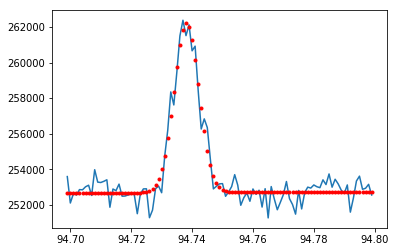

In [2]:
figure()
plot(d.kthZebra, d.wcroi_sum)
fit(g_lin)

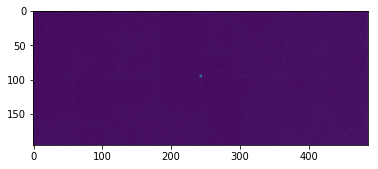

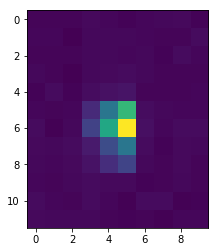

In [3]:
xy_cen = [244, 95]
xy_wid = [10, 12]

figure()
im1=pil(40).image_01
imshow(im1)
im1[95, 244]
roi = im1[(xy_cen[1]-xy_wid[1]/2):(xy_cen[1]+xy_wid[1]/2), (xy_cen[0]-xy_wid[0]/2):(xy_cen[0]+xy_wid[0]/2)]
figure()
imshow(roi)



In [4]:
#np.argmax(roi, axis=1)
np.where(roi == roi.max)

(array([], dtype=int64), array([], dtype=int64))

In [2]:
ci, cj = 242, 95	#26/9/18

def peak_index(np_array):
    idx = np.where(np_array == np.amax(np_array))
    return (idx[0][0], idx[1][0])

def gauss(ilen, jlen, icen, jcen, iwid, jwid):
    _im, _jm = np.meshgrid(range(ilen), range(jlen), indexing = 'ij')
    return np.exp(-(1.0*(_im-icen)/iwid)**2) * np.exp(-(1.0*(_jm-jcen)/jwid)**2)

def fit_peak_cent(scan_obj, ci, cj, iw, jw, showfit=False):
    pil=dataloader.tiffloader(scan_obj, lambda obj: datadir+obj.pilatus3_100k_path_template)
    idx_i, idx_j, pk = [], [], []
    im = pil(1).image_01
    g = gauss(im.shape[0], im.shape[1], cj, ci, iw, jw)
    
    for im_no in scan_obj.path:     
        im = pil(im_no).image_01
        idx = peak_index(im * g)
        idx_i += [idx[0]]
        idx_j += [idx[1]]
        pk += [im[idx]]
        
    weight = np.sqrt(np.array(pk)) * g[idx_i, idx_j]
    im_no_array = np.array(d.path)
    fit_prm_i = np.polyfit(im_no_array, idx_i, 1, w=weight)
    fit_prm_j = np.polyfit(im_no_array, idx_j, 1, w=weight)
    
    if showfit:
        fit_i = fit_prm_i[0] * im_no_array + fit_prm_i[1]
        fit_j = fit_prm_j[0] * im_no_array + fit_prm_j[1]
        figure(); plot(idx_i); plot(idx_j); plot(weight); plot(fit_i); plot(fit_j)

    return (fit_prm_i, fit_prm_j)

def get_peak_intensity(scan_obj, i_cen, j_cen, i_wid, j_wid):
    #get peak-background point-by-point in scan
   
    #fit to get peak centre throughout scan
    (fit_prm_i, fit_prm_j) = fit_peak_cent(d, ci, cj, 10, 10)

    peak_int = []
    for im_no in scan_obj.path:
        im = pil(im_no).image_01
        i_cen = fit_prm_i[0] * im_no + fit_prm_i[1]
        j_cen = fit_prm_j[0] * im_no + fit_prm_j[1]

        icen = int(np.round(i_cen))
        jcen = int(np.round(j_cen))

        iw = 10; jw = 10
        roi = im[(icen-iw/2):(icen+iw/2), (jcen-jw/2):(jcen+jw/2)]

        roi_flat_sort = np.sort(roi.flatten())
        n_tot_pix, n_bg_pix = len(roi_flat_sort), len(roi_flat_sort)/2
        peak_int += [roi_flat_sort.sum() - 1.0*n_tot_pix/n_bg_pix*roi_flat_sort[0:n_bg_pix].sum()]
        #removes most background but slight underestimate due to stats in background

    return np.array(peak_int)
    
    
def get_peak_intensity_with_deadtime_correction(scan_obj, i_cen, j_cen, i_wid, j_wid, dt_func, ctime):
    #get peak-background point-by-point in scan
   
    #fit to get peak centre throughout scan
    (fit_prm_i, fit_prm_j) = fit_peak_cent(d, ci, cj, 10, 10)

    peak_int = []
    for im_no in scan_obj.path:
        im = pil(im_no).image_01
        i_cen = fit_prm_i[0] * im_no + fit_prm_i[1]
        j_cen = fit_prm_j[0] * im_no + fit_prm_j[1]

        icen = int(np.round(i_cen))
        jcen = int(np.round(j_cen))

        iw = 10; jw = 10
        roi = im[(icen-iw/2):(icen+iw/2), (jcen-jw/2):(jcen+jw/2)]

        roi = dt_func(roi/ctime) * ctime #dt_func corrects for deadtime, assuming counts are per sec
        
        
        roi_flat_sort = np.sort(roi.flatten())
        n_tot_pix, n_bg_pix = len(roi_flat_sort), len(roi_flat_sort)/2
        peak_int += [roi_flat_sort.sum() - 1.0*n_tot_pix/n_bg_pix*roi_flat_sort[0:n_bg_pix].sum()]
        #removes most background but slight underestimate due to stats in background

    return np.array(peak_int)




[94.53028039440494, 0.008833561124331962, 306608.88013172365, 28129.76158068057, 306.6088801317209, 881.4489571899269, -81968.01295280155]


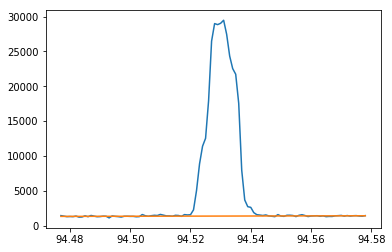

In [5]:
scan = 759523
figure()
d(scan)
peak_int_vs_kth = get_peak_intensity(d, cj, ci, 10, 10)
plot(d.kthZebra, peak_int_vs_kth)
[centre, width, sum, height, area, m, c]=peak(d.kthZebra,peak_int_vs_kth,nbgpts=10)

print [centre, width, sum, height, area, m, c]
plot(d.kthZebra, m * d.kthZebra + c)

In [84]:
#process every scan in experiment
for scan in range(746395, 775742):
    try:
        peak_int_vs_kth = get_peak_intensity(d(scan), cj, ci, 10, 10)
        np.savetxt('/dls/i16/data/2019/mm22314-1/processing/pilatus_peak_intensities_2/%i' % scan, peak_int_vs_kth)
        if scan%100 == 0:
            print scan
    except:
        print "=== scan %i went wrong" % scan



746400
=== scan 746404 went wrong
=== scan 746405 went wrong
=== scan 746408 went wrong
=== scan 746409 went wrong
=== scan 746410 went wrong
=== scan 746411 went wrong
=== scan 746412 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:2

=== scan 746419 went wrong
=== scan 746420 went wrong
=== scan 746421 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746422 went wrong
=== scan 746423 went wrong
=== scan 746424 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746426 went wrong
=== scan 746427 went wrong
=== scan 746428 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746429 went wrong
=== scan 746430 went wrong
=== scan 746431 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746432 went wrong
=== scan 746433 went wrong
=== scan 746461 went wrong
=== scan 746469 went wrong
=== scan 746470 went wrong
=== scan 746471 went wrong
=== scan 746472 went wrong
=== scan 746473 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746498 went wrong
746500
746600
746700
=== scan 746709 went wrong
=== scan 746711 went wrong
=== scan 746718 went wrong
746800
=== scan 746896 went wrong
=== scan 746897 went wrong
746900
747000
747100
747200
747300
747400
747500
747600
747700
747800
747900
748000
748100
748200
748300
748400
748500
748600
=== scan 748692 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748693 went wrong
=== scan 748694 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748698 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748700


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748702 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748706 went wrong
=== scan 748707 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748708 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748711 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748712 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748713 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748715 went wrong
=== scan 748717 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748720 went wrong
=== scan 748721 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748722 went wrong
=== scan 748723 went wrong
=== scan 748724 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748725 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748726 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748727 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748729 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748730 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748731 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748732 went wrong
748800
748900
749000
749100
749200
749300
749400
749500
749600
749700
749800
749900
750000
750100
750200
750300
=== scan 750357 went wrong
=== scan 750359 went wrong
=== scan 750360 went wrong
=== scan 750364 went wrong
=== scan 750365 went wrong
=== scan 750366 went wrong
=== scan 750367 went wrong
=== scan 750368 went wrong
=== scan 750370 went wrong
=== scan 750371 went wrong
=== scan 750373 went wrong
=== scan 750379 went wrong
=== scan 750380 went wrong
=== scan 750381 went wrong
=== scan 750382 went wrong
=== scan 750383 went wrong
=== scan 750384 went wrong
=== scan 750385 went wrong
=== scan 750386 went wrong
=== scan 750387 went wrong
=== scan 750389 went wrong
=== scan 750390 went wrong
=== scan 750391 went wrong
=== scan 750392 went wrong
=== scan 750393 went wrong
=== scan 750394 went wrong
750400
750500
=== scan 750544 went wrong
=== scan 750546 went wrong
=== scan 750549 went wrong
=== scan 750550 went wrong
750600
=== scan 750688 went wrong
750

/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752079 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752081 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752086 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752088 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752089 went wrong
=== scan 752091 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752092 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752095 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752096 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752100 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:2

=== scan 752105 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752106 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:2

=== scan 752112 went wrong
=== scan 752113 went wrong
=== scan 752114 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752118 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752120 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752123 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752126 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752130 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752133 went wrong
=== scan 752134 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752135 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752137 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752140 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752145 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752147 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:2

=== scan 752159 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752161 went wrong
=== scan 752162 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752164 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752168 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752170 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752172 went wrong
=== scan 752173 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752176 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752177 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752178 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752180 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752182 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752184 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752185 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752188 went wrong
=== scan 752189 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752192 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752195 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752198 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752199 went wrong
752200


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752206 went wrong
752300
=== scan 752344 went wrong
752400
=== scan 752482 went wrong
752500
752600
=== scan 752620 went wrong
752700
=== scan 752758 went wrong
752800
=== scan 752896 went wrong
752900
753000
=== scan 753034 went wrong
753100
=== scan 753172 went wrong
753200
753300
=== scan 753310 went wrong
=== scan 753313 went wrong
=== scan 753314 went wrong
=== scan 753316 went wrong
=== scan 753317 went wrong
753400
753500
753600
753700
=== scan 753780 went wrong
=== scan 753781 went wrong
753800
753900
=== scan 753918 went wrong
=== scan 753919 went wrong
754000
=== scan 754056 went wrong
=== scan 754057 went wrong
754100
=== scan 754194 went wrong
=== scan 754195 went wrong
754200
754300
=== scan 754332 went wrong
=== scan 754333 went wrong
754400
=== scan 754470 went wrong
=== scan 754471 went wrong
754500
754600
=== scan 754608 went wrong
=== scan 754609 went wrong
754700
=== scan 754746 went wrong
=== scan 754747 went wrong
754800
=== scan 754884 went wrong
=== scan

/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


763700
763800
763900
764000
764100
764200
764300
764400
764500
764600
764700
764800
764900
765000
765100
765200
765300
765400
765500
765600
765700
765800
765900
766000
766100
766200
766300
766400
766500
766600
766700
766800
766900
767000
767100
767200
767300
767400
767500
767600
767700
767800
767900
768000
768100
768200
768300
768400
768500
768600
768700
768800
768900
769000
769100
769200
769300
769400
769500
769600
769700
769800
769900
770000
770100
770200
770300
770400
770500
770600
770700
770800
770900
771000
771100
771200
771300
771400
771500
771600
771700
771800
771900
772000
772100
772200
772300
772400
772500
772600
772700
772800
772900
773000
773100
773200
=== scan 773222 went wrong
773300
773400
=== scan 773479 went wrong
773500
773600
773700
=== scan 773736 went wrong
773800
773900
=== scan 773993 went wrong
774000
774100
774200
=== scan 774250 went wrong
774300
774400
774500
=== scan 774507 went wrong
774600
774700
=== scan 774764 went wrong
774800
774900
775000
775100
775200

=== Error scan 762245


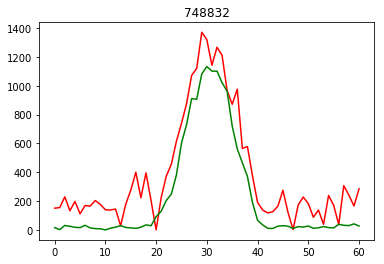

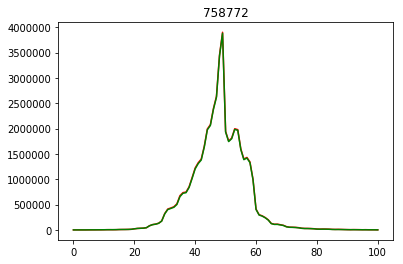

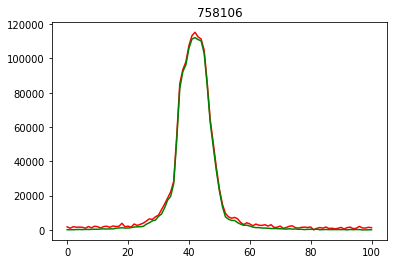

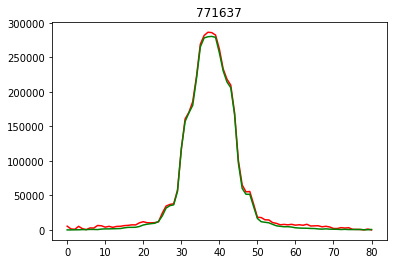

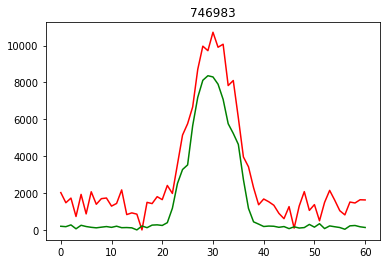

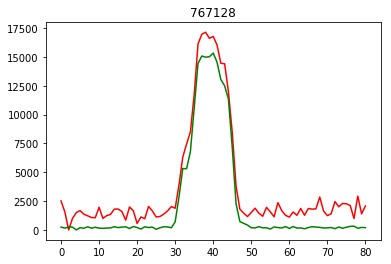

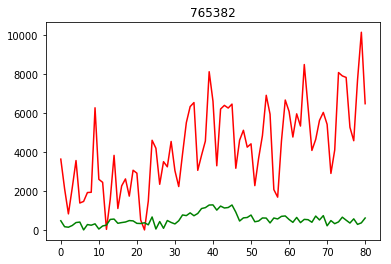

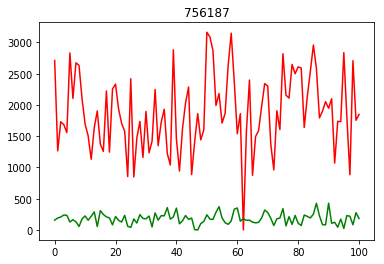

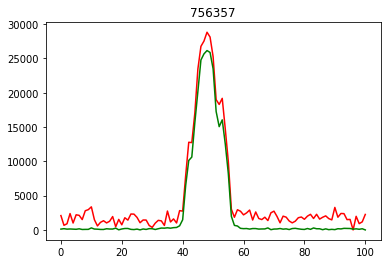

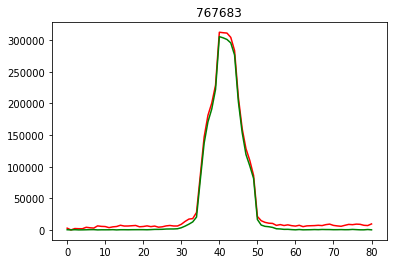

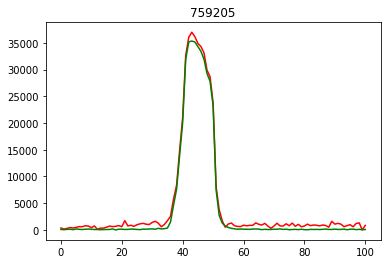

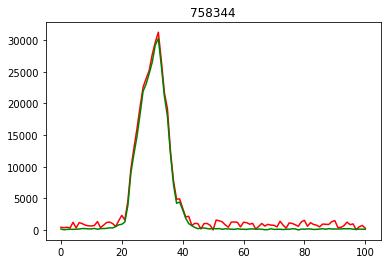

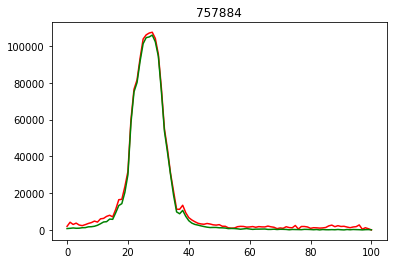

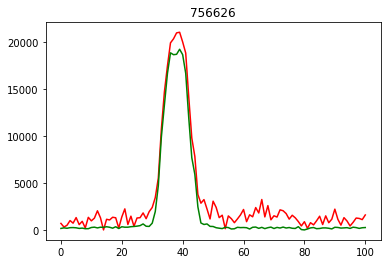

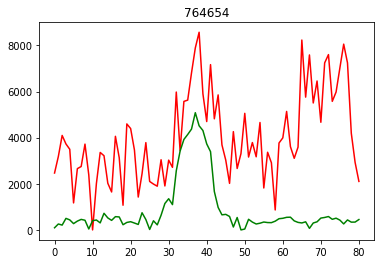

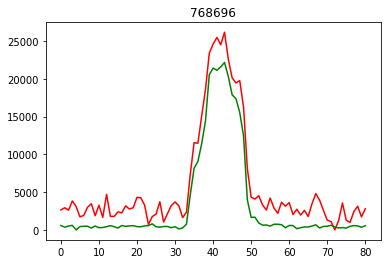

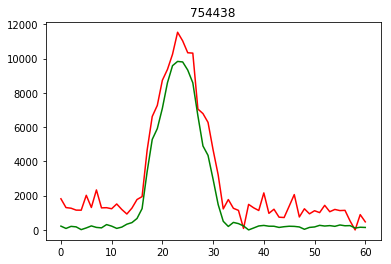

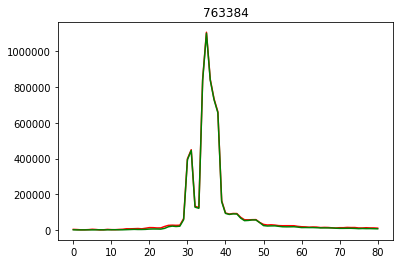

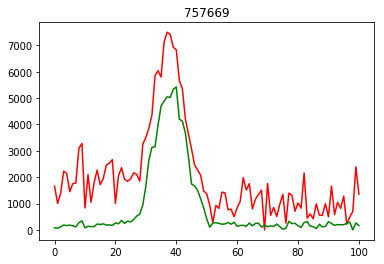

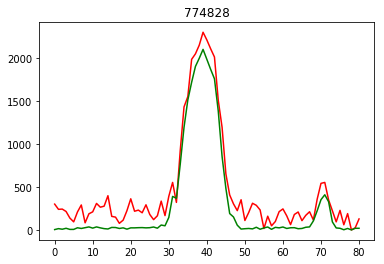

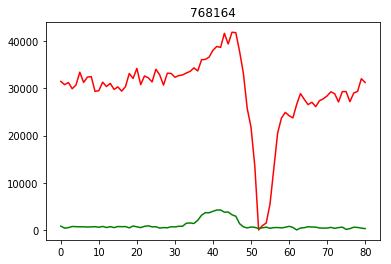

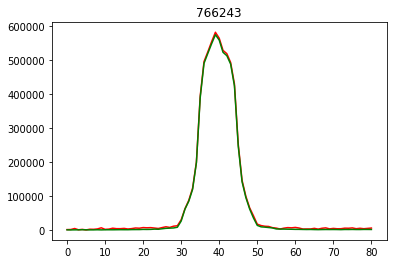

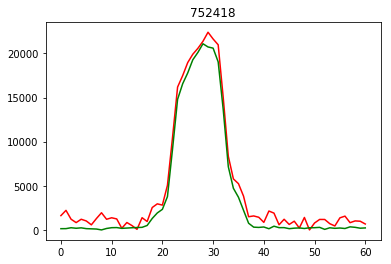

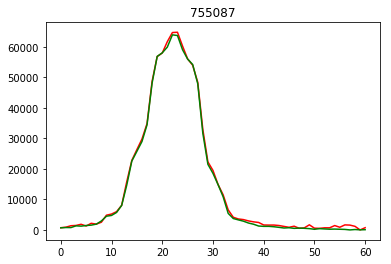

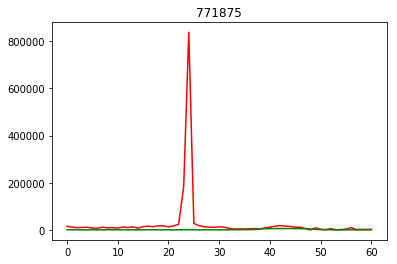

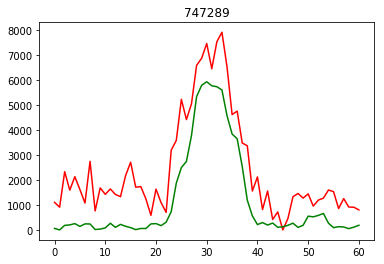

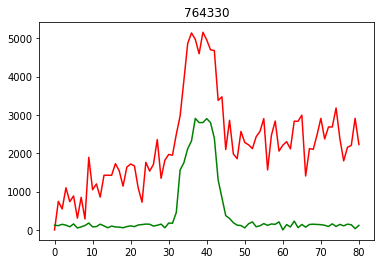

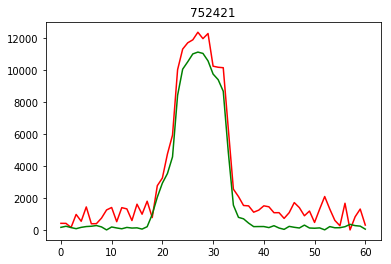

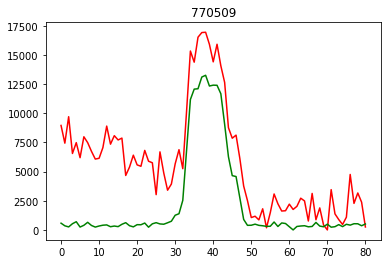

In [105]:
#test results with random selection

import numpy.random as rnd
%matplotlib inline

istart, iend = 746395, 775742
for i in range(30):
    figure()
    scan = int(istart + rnd.rand()*(iend-istart))
    d(scan)
    n=pdnx(p % scan)
    try:
        try:
            plot(n.wcroi_sum-min(n.wcroi_sum), color='r')
        except:
            plot(n.roi2_sum-min(n.roi2_sum), color='r')
        pkint = np.loadtxt('/dls/i16/data/2019/mm22314-1/processing/pilatus_peak_intensities_2/%i' % scan)
        plot(pkint-min(pkint), color = 'g')
        title(str(scan))
    except:
        print "=== Error scan %i" % scan



        



In [96]:
for scan in [755910]:
    peak_int_vs_kth = get_peak_intensity(d(scan), cj, ci, 10, 10)
    print peak_int_vs_kth

ValueError: File /dls/i16/data/2019/mm22314-1/746511-pilatus3_100k-files/00022.tif does not exist

746400
=== Error loading file /dls/i16/data/2019/mm22314-1/746404.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746405.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746408.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746409.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746410.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746411.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746412.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746433.nxs
746500
746600
746700
=== Error loading file /dls/i16/data/2019/mm22314-1/746709.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746711.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746718.nxs
746800
746900
747000
747100
747200
747300
747400
747500
747600
747700
747800
747900
748000
748100
748200
748300
748400
748500
748600
748700
748800
748900
749000
749100
749200
749300
749400
749500
749600
749700
749800
749900
750000
750100
750200
750300
=== Error loading file /dls

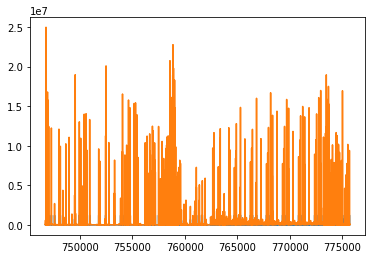

In [22]:
#check max pixel count rate

# count-time is 0.1 sec
scn, maxmax, maxsum = [], [], []

for scan in range(746395, 775742):
#for scan in range(770000, 770100):
    try:
        n = pdnx(p % scan)
        if 'kthZebra' in n.scan and 'roi1' in n.scan:
            scn += [scan]
            maxmax += [np.max(n.roi1_maxval)]
            maxsum += [np.max(n.roi1_sum)]
        if scan%100 == 0:
            print scan
    except:
        pass
np.savetxt('/dls/i16/data/2019/mm22314-1/processing/pilatus_peak_intensities_2/all_kthzebra_maxval.txt', [scn, maxmax, maxsum])    

figure()
plot(scn, maxmax)
plot(scn, maxsum)

<IPython.core.display.Javascript object>


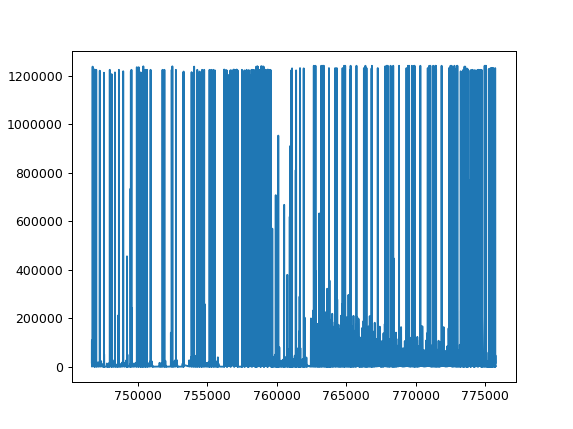

In [24]:
%matplotlib notebook 
figure()
plot(scn, maxmax)

In [18]:
n.scan

u'/dls/i16/data/2019/mm22314-1/770009.nxs\nscan kthZebra 88.00832682931544 88.08832682931545 0.001 pil3_100k 0.1 roi2 roi1 wcroi'

In [94]:
######
######
#
# all seem to look much better that ROI data
# next: write deadtime correction function
#
#
######
######

746400
=== Error loading file /dls/i16/data/2019/mm22314-1/746404.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746405.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746408.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746409.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746410.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746411.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746412.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746433.nxs
746500
746600
746700
=== Error loading file /dls/i16/data/2019/mm22314-1/746709.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746711.nxs
=== Error loading file /dls/i16/data/2019/mm22314-1/746718.nxs
746800
746900
747000
747100
747200
747300
747400
747500
747600
747700
747800
747900
748000
748100
748200
748300
748400
748500
748600
748700
748800
748900
749000
749100
749200
749300
749400
749500
749600
749700
749800
749900
750000
750100
750200
750300
=== Error loading file /dls

<IPython.core.display.Javascript object>


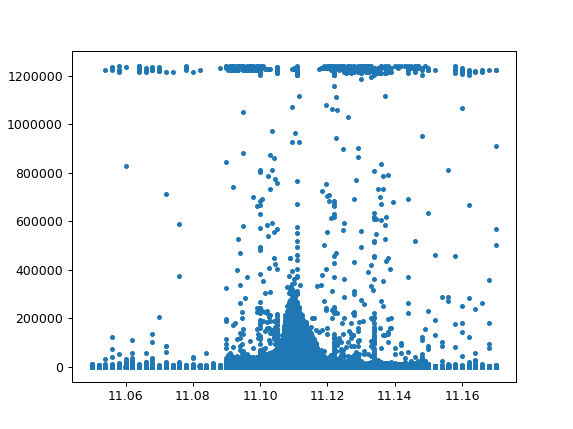

In [31]:
#check max pixel count rate

# count-time is 0.1 sec
scn, maxmax, maxsum, energy = [], [], [], []

for scan in range(746395, 775742):
#for scan in range(770000, 770100):
    try:
        n = pdnx(p % scan)
        if 'kthZebra' in n.scan and 'roi1' in n.scan:
            scn += [scan]
            maxmax += [np.max(n.roi1_maxval)]
            maxsum += [np.max(n.roi1_sum)]
            energy += [float(n.nx.entry1.before_scan.mono.en)]
        if scan%100 == 0:
            print scan
    except:
        pass

figure()
#plot(scn, maxmax)
#plot(scn, maxsum)
plot(energy, maxmax,'.')

<IPython.core.display.Javascript object>


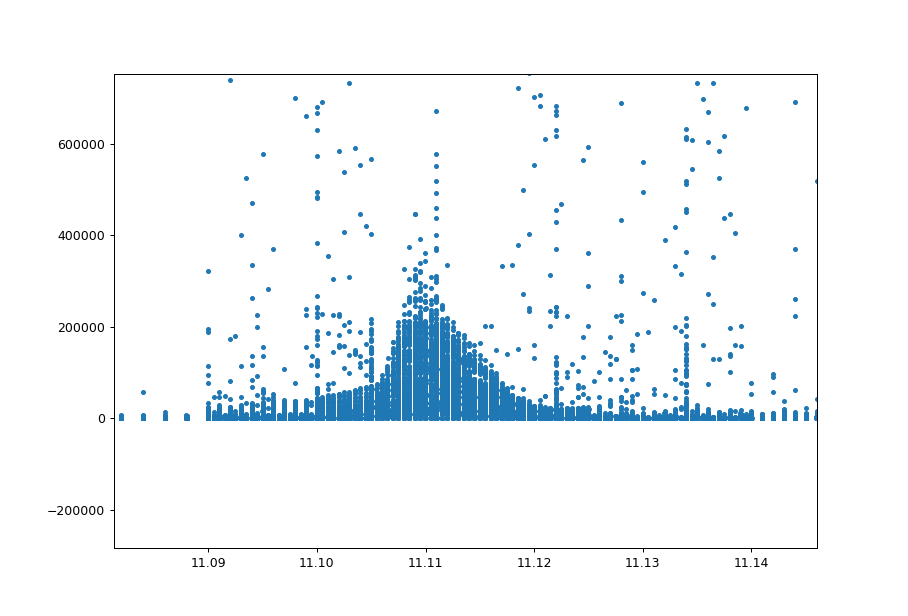

In [32]:
figure()
#plot(scn, maxmax)
#plot(scn, maxsum)
plot(energy, maxmax,'.')

# Now repeat with deadtime correction from pilatus_deadtime_may_2019

In [40]:

#deadtime correction. Counts in cps. Parameters from fit to deadtime calibration data
def corrected(x):
    [p1, p2, p3, x0, q1, q2, q3] = [
       1.457047192214227,
       -1.6396060309159249e-06,
       1.4132902753176387e-12,
       1400000.0,
       1.753447433492027,
       -1.5181323796095546e-07,
       9.484579611828304e-15]
    return (x<x0)*(x*p1 + x**2*p2 + x**3*p3) + (x>=x0)* ((x0*p1 +x0**2*p2+x0**3*p3) + (x-x0)*q1 + (x-x0)**2 * q2 + + (x-x0)**3 * q3)


#process every scan in experiment
for scan in range(746395, 775742):
#for scan in range(746395, 746425):
    try:
        peak_int_vs_kth = get_peak_intensity_with_deadtime_correction(d(scan), cj, ci, 10, 10, corrected, 0.1)
        np.savetxt('/dls/i16/data/2019/mm22314-1/processing/pilatus_peak_intensities_3/%i' % scan, peak_int_vs_kth)
        if scan%100 == 0:
            print scan
    except:
        print "=== scan %i went wrong" % scan

/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746395 went wrong
=== scan 746396 went wrong
746400
=== scan 746404 went wrong
=== scan 746405 went wrong
=== scan 746408 went wrong
=== scan 746409 went wrong
=== scan 746410 went wrong
=== scan 746411 went wrong
=== scan 746412 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:2

=== scan 746419 went wrong
=== scan 746420 went wrong
=== scan 746421 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746422 went wrong
=== scan 746423 went wrong
=== scan 746424 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746426 went wrong
=== scan 746427 went wrong
=== scan 746428 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746429 went wrong
=== scan 746430 went wrong
=== scan 746431 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746432 went wrong
=== scan 746433 went wrong
=== scan 746461 went wrong
=== scan 746469 went wrong
=== scan 746470 went wrong
=== scan 746471 went wrong
=== scan 746472 went wrong
=== scan 746473 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746498 went wrong
746500
746600
746700
=== scan 746709 went wrong
=== scan 746711 went wrong
=== scan 746718 went wrong
746800
=== scan 746896 went wrong
=== scan 746897 went wrong
746900
747000
747100
747200
747300
747400
747500
747600
747700
747800
747900
748000
748100
748200
748300
748400
748500
748600
=== scan 748692 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748693 went wrong
=== scan 748694 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748698 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748700


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748702 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748706 went wrong
=== scan 748707 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748708 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748711 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748712 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748713 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748715 went wrong
=== scan 748717 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748720 went wrong
=== scan 748721 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748722 went wrong
=== scan 748723 went wrong
=== scan 748724 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748725 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748726 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748727 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748729 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748730 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748731 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748732 went wrong
748800
748900
749000
749100
749200
749300
749400
749500
749600
749700
749800
749900
750000
750100
750200
750300
=== scan 750357 went wrong
=== scan 750359 went wrong
=== scan 750360 went wrong
=== scan 750364 went wrong
=== scan 750365 went wrong
=== scan 750366 went wrong
=== scan 750367 went wrong
=== scan 750368 went wrong
=== scan 750370 went wrong
=== scan 750371 went wrong
=== scan 750373 went wrong
=== scan 750379 went wrong
=== scan 750380 went wrong
=== scan 750381 went wrong
=== scan 750382 went wrong
=== scan 750383 went wrong
=== scan 750384 went wrong
=== scan 750385 went wrong
=== scan 750386 went wrong
=== scan 750387 went wrong
=== scan 750389 went wrong
=== scan 750390 went wrong
=== scan 750391 went wrong
=== scan 750392 went wrong
=== scan 750393 went wrong
=== scan 750394 went wrong
750400
750500
=== scan 750544 went wrong
=== scan 750546 went wrong
=== scan 750549 went wrong
=== scan 750550 went wrong
750600
=== scan 750688 went wrong
750

/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752079 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752081 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752086 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752088 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752089 went wrong
=== scan 752091 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752092 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752095 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752096 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752100 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:2

=== scan 752105 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752106 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:2

=== scan 752112 went wrong
=== scan 752113 went wrong
=== scan 752114 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752118 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752120 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752123 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752126 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752130 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752133 went wrong
=== scan 752134 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752135 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752137 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752140 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752145 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752147 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:2

=== scan 752159 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752161 went wrong
=== scan 752162 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752164 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752168 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752170 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752172 went wrong
=== scan 752173 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752176 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752177 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: divide by zero encountered in true_divide
  lhs /= scale
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752178 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752180 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752182 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752184 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752185 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752188 went wrong
=== scan 752189 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752192 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752195 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752198 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752199 went wrong
752200


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752206 went wrong
752300
=== scan 752344 went wrong
752400
=== scan 752482 went wrong
752500
752600
=== scan 752620 went wrong
752700
=== scan 752758 went wrong
752800
=== scan 752896 went wrong
752900
753000
=== scan 753034 went wrong
753100
=== scan 753172 went wrong
753200
753300
=== scan 753310 went wrong
=== scan 753313 went wrong
=== scan 753314 went wrong
=== scan 753316 went wrong
=== scan 753317 went wrong
753400
753500
753600
753700
=== scan 753780 went wrong
=== scan 753781 went wrong
753800
753900
=== scan 753918 went wrong
=== scan 753919 went wrong
754000
=== scan 754056 went wrong
=== scan 754057 went wrong
754100
=== scan 754194 went wrong
=== scan 754195 went wrong
754200
754300
=== scan 754332 went wrong
=== scan 754333 went wrong
754400
=== scan 754470 went wrong
=== scan 754471 went wrong
754500
754600
=== scan 754608 went wrong
=== scan 754609 went wrong
754700
=== scan 754746 went wrong
=== scan 754747 went wrong
754800
=== scan 754884 went wrong
=== scan

/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


763700
763800
763900
764000
764100
764200
764300
764400
764500
764600
764700
764800
764900
765000
765100
765200
765300
765400
765500
765600
765700
765800
765900
766000
766100
766200
766300
766400
766500
766600
766700
766800
766900
767000
767100
767200
767300
767400
767500
767600
767700
767800
767900
768000
768100
768200
768300
768400
768500
768600
768700
768800
768900
769000
769100
769200
769300
769400
769500
769600
769700
769800
769900
770000
770100
770200
770300
770400
770500
770600
770700
770800
770900
771000
771100
771200
771300
771400
771500
771600
771700
771800
771900
772000
772100
772200
772300
772400
772500
772600
772700
772800
772900
773000
773100
773200
=== scan 773222 went wrong
773300
773400
=== scan 773479 went wrong
773500
773600
773700
=== scan 773736 went wrong
773800
773900
=== scan 773993 went wrong
774000
774100
774200
=== scan 774250 went wrong
774300
774400
774500
=== scan 774507 went wrong
774600
774700
=== scan 774764 went wrong
774800
774900
775000
775100
775200

In [ ]:
## do all scans then repeat tests as per before correction
##  29116 files in total (29117 in previous analysis)


=== Error scan 755650


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


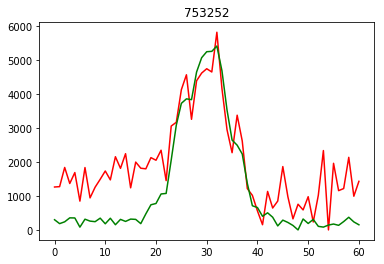

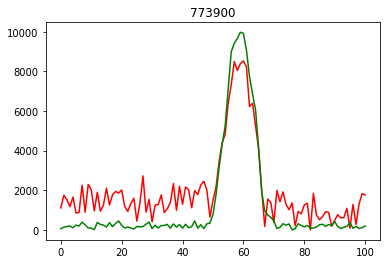

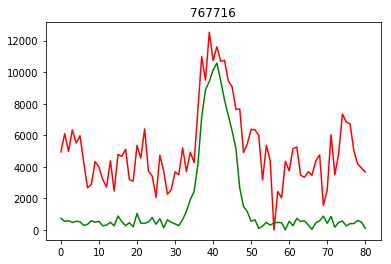

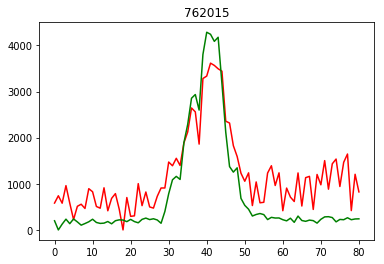

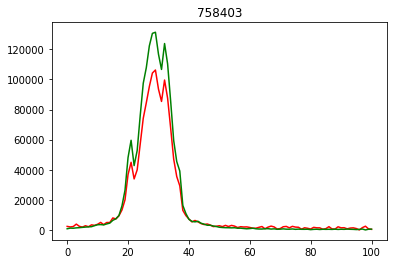

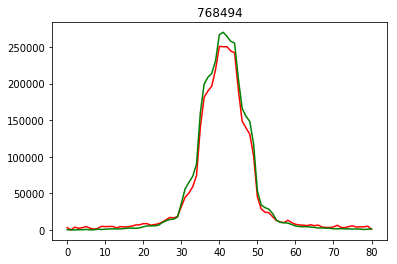

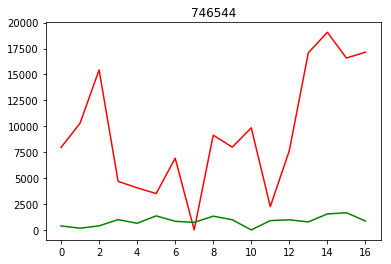

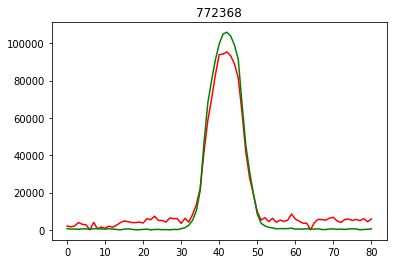

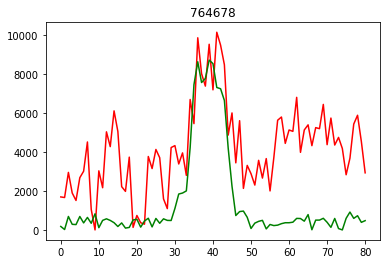

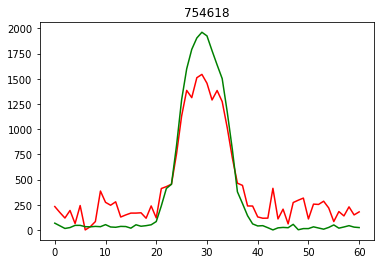

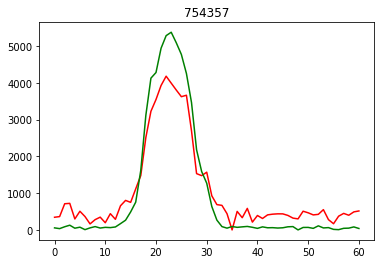

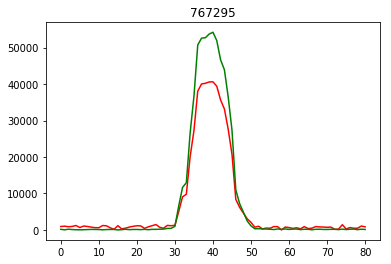

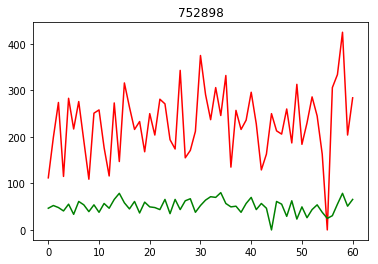

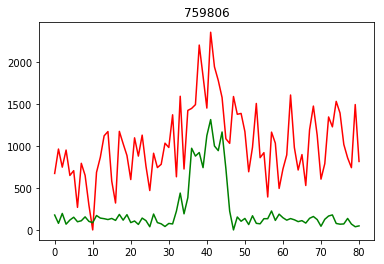

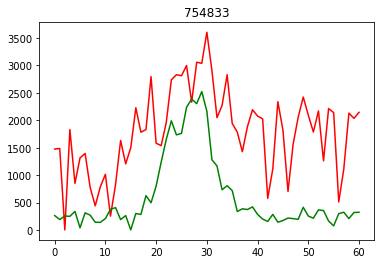

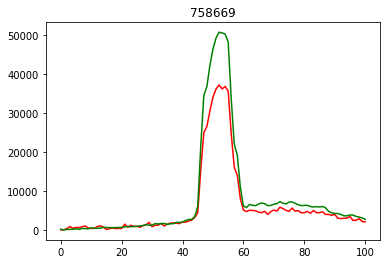

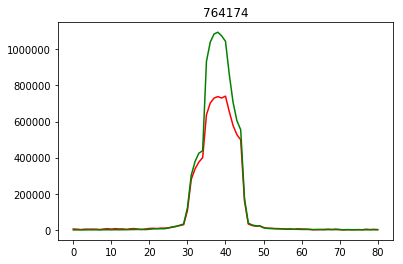

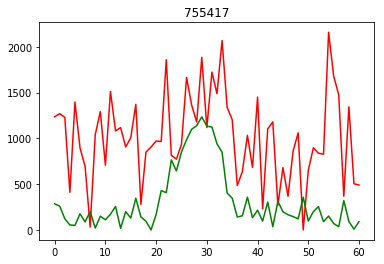

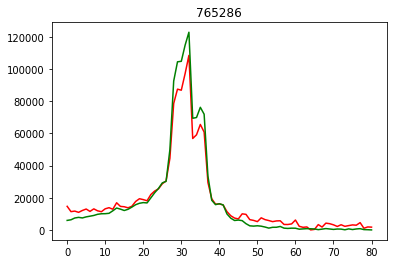

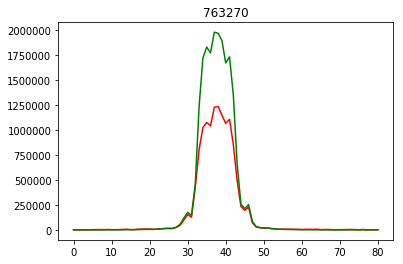

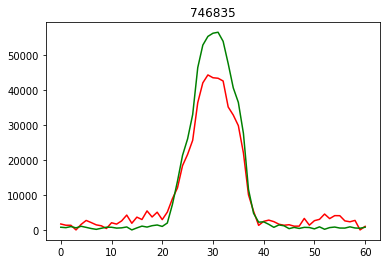

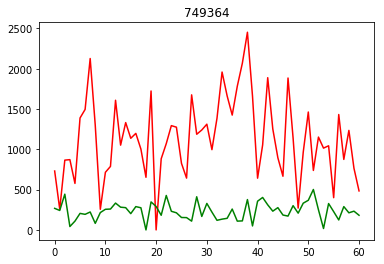

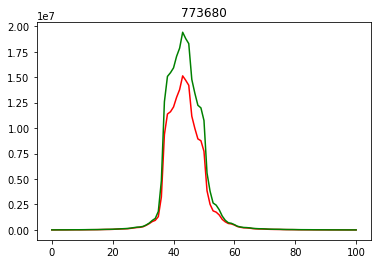

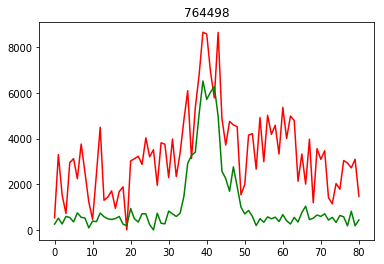

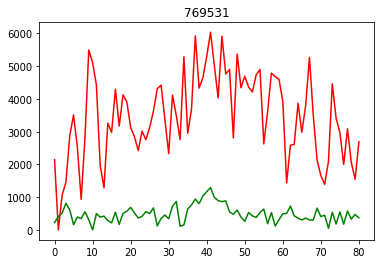

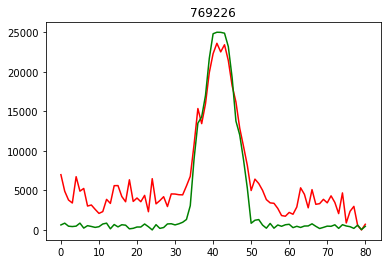

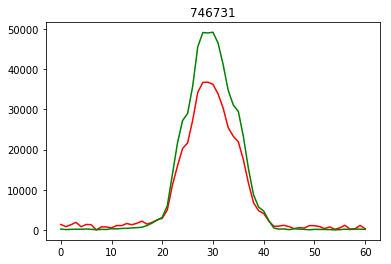

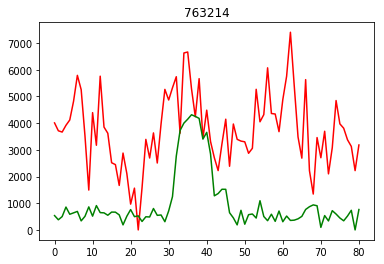

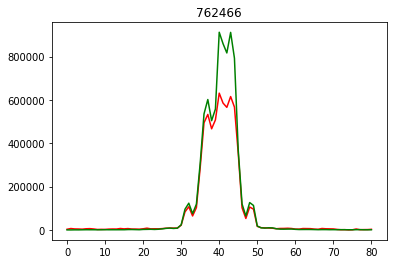

In [41]:
#test results with random selection

import numpy.random as rnd
%matplotlib inline

istart, iend = 746395, 775742
for i in range(30):
    figure()
    scan = int(istart + rnd.rand()*(iend-istart))
    d(scan)
    n=pdnx(p % scan)
    try:
        try:
            plot(n.wcroi_sum-min(n.wcroi_sum), color='r')
        except:
            plot(n.roi2_sum-min(n.roi2_sum), color='r')
        pkint = np.loadtxt('/dls/i16/data/2019/mm22314-1/processing/pilatus_peak_intensities_3/%i' % scan)
        plot(pkint-min(pkint), color = 'g')
        title(str(scan))
    except:
        print "=== Error scan %i" % scan


# check why some files missing: 77575* failed
# repeat script - seems ok now with no change

In [7]:

#deadtime correction. Counts in cps. Parameters from fit to deadtime calibration data
def corrected(x):
    [p1, p2, p3, x0, q1, q2, q3] = [
       1.457047192214227,
       -1.6396060309159249e-06,
       1.4132902753176387e-12,
       1400000.0,
       1.753447433492027,
       -1.5181323796095546e-07,
       9.484579611828304e-15]
    return (x<x0)*(x*p1 + x**2*p2 + x**3*p3) + (x>=x0)* ((x0*p1 +x0**2*p2+x0**3*p3) + (x-x0)*q1 + (x-x0)**2 * q2 + + (x-x0)**3 * q3)


#process every scan in experiment
for scan in range(746395, 775742):
#for scan in range(775740, 776043):
    try:
        peak_int_vs_kth = get_peak_intensity_with_deadtime_correction(d(scan), cj, ci, 10, 10, corrected, 0.1)
        np.savetxt('/dls/i16/data/2019/mm22314-1/processing/pilatus_peak_intensities_3/%i' % scan, peak_int_vs_kth)
        #if scan%100 == 0:
        print scan
    except:
        print "=== scan %i went wrong" % scan

746395
746396
746397
746398
746399
746400
746401
746402
746403
=== scan 746404 went wrong
=== scan 746405 went wrong
746406
746407
=== scan 746408 went wrong
=== scan 746409 went wrong
=== scan 746410 went wrong
=== scan 746411 went wrong
=== scan 746412 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


746413


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


746414


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


746415


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


746416


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


746417


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


746418


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/numpy/lib/polynomial.py:586: RuntimeWarning: invalid value encountered in true_divide
  c = (c.T/scale).T  # broadcast scale coefficients
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw

=== scan 746419 went wrong
=== scan 746420 went wrong
=== scan 746421 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746422 went wrong
=== scan 746423 went wrong
=== scan 746424 went wrong
746425
=== scan 746426 went wrong
=== scan 746427 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746428 went wrong
=== scan 746429 went wrong
=== scan 746430 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746431 went wrong
=== scan 746432 went wrong
=== scan 746433 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


746434
746435
746436
746437
746438
746439
746440
746441
746442
746443
746444
746445
746446
746447
746448
746449
746450
746451
746452
746453
746454
746455
746456
746457
746458
746459
746460
=== scan 746461 went wrong
746462
746463
746464
746465
746466
746467
746468
=== scan 746469 went wrong
=== scan 746470 went wrong
=== scan 746471 went wrong
=== scan 746472 went wrong
=== scan 746473 went wrong
746474
746475
746476
746477
746478
746479
746480
746481
746482
746483
746484
746485
746486
746487
746488
746489
746490
746491
746492
746493
746494
746495
746496
746497


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 746498 went wrong
746499
746500
746501
746502
746503
746504
746505
746506
746507
746508
746509
746510
746511
746512
746513
746514
746515
746516
746517
746518
746519
746520
746521
746522
746523
746524
746525
746526
746527
746528
746529
746530
746531
746532
746533
746534
746535
746536
746537
746538
746539
746540
746541
746542
746543
746544
746545
746546
746547
746548
746549
746550
746551
746552
746553
746554
746555
746556
746557
746558
746559
746560
746561
746562
746563
746564
746565
746566
746567
746568
746569
746570
746571
746572
746573
746574
746575
746576
746577
746578
746579
746580
746581
746582
746583
746584
746585
746586
746587
746588
746589
746590
746591
746592
746593
746594
746595
746596
746597
746598
746599
746600
746601
746602
746603
746604
746605
746606
746607
746608
746609
746610
746611
746612
746613
746614
746615
746616
746617
746618
746619
746620
746621
746622
746623
746624
746625
746626
746627
746628
746629
746630
746631
746632
746633
746634
746635
746636
746637


747652
747653
747654
747655
747656
747657
747658
747659
747660
747661
747662
747663
747664
747665
747666
747667
747668
747669
747670
747671
747672
747673
747674
747675
747676
747677
747678
747679
747680
747681
747682
747683
747684
747685
747686
747687
747688
747689
747690
747691
747692
747693
747694
747695
747696
747697
747698
747699
747700
747701
747702
747703
747704
747705
747706
747707
747708
747709
747710
747711
747712
747713
747714
747715
747716
747717
747718
747719
747720
747721
747722
747723
747724
747725
747726
747727
747728
747729
747730
747731
747732
747733
747734
747735
747736
747737
747738
747739
747740
747741
747742
747743
747744
747745
747746
747747
747748
747749
747750
747751
747752
747753
747754
747755
747756
747757
747758
747759
747760
747761
747762
747763
747764
747765
747766
747767
747768
747769
747770
747771
747772
747773
747774
747775
747776
747777
747778
747779
747780
747781
747782
747783
747784
747785
747786
747787
747788
747789
747790
747791
747792
747793
747794

/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748693 went wrong
=== scan 748694 went wrong
748695


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748696
748697


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748698 went wrong
748699


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748700
748701


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748702 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748703
748704


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748705
=== scan 748706 went wrong
=== scan 748707 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748708 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748709


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748710


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748711 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748712 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748713 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748714


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748715 went wrong
748716
=== scan 748717 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748718


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748719
=== scan 748720 went wrong
=== scan 748721 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748722 went wrong
=== scan 748723 went wrong
=== scan 748724 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748725 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748726 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748727 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


748728


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748729 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748730 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748731 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 748732 went wrong
748733
748734
748735
748736
748737
748738
748739
748740
748741
748742
748743
748744
748745
748746
748747
748748
748749
748750
748751
748752
748753
748754
748755
748756
748757
748758
748759
748760
748761
748762
748763
748764
748765
748766
748767
748768
748769
748770
748771
748772
748773
748774
748775
748776
748777
748778
748779
748780
748781
748782
748783
748784
748785
748786
748787
748788
748789
748790
748791
748792
748793
748794
748795
748796
748797
748798
748799
748800
748801
748802
748803
748804
748805
748806
748807
748808
748809
748810
748811
748812
748813
748814
748815
748816
748817
748818
748819
748820
748821
748822
748823
748824
748825
748826
748827
748828
748829
748830
748831
748832
748833
748834
748835
748836
748837
748838
748839
748840
748841
748842
748843
748844
748845
748846
748847
748848
748849
748850
748851
748852
748853
748854
748855
748856
748857
748858
748859
748860
748861
748862
748863
748864
748865
748866
748867
748868
748869
748870
748871


749900
749901
749902
749903
749904
749905
749906
749907
749908
749909
749910
749911
749912
749913
749914
749915
749916
749917
749918
749919
749920
749921
749922
749923
749924
749925
749926
749927
749928
749929
749930
749931
749932
749933
749934
749935
749936
749937
749938
749939
749940
749941
749942
749943
749944
749945
749946
749947
749948
749949
749950
749951
749952
749953
749954
749955
749956
749957
749958
749959
749960
749961
749962
749963
749964
749965
749966
749967
749968
749969
749970
749971
749972
749973
749974
749975
749976
749977
749978
749979
749980
749981
749982
749983
749984
749985
749986
749987
749988
749989
749990
749991
749992
749993
749994
749995
749996
749997
749998
749999
750000
750001
750002
750003
750004
750005
750006
750007
750008
750009
750010
750011
750012
750013
750014
750015
750016
750017
750018
750019
750020
750021
750022
750023
750024
750025
750026
750027
750028
750029
750030
750031
750032
750033
750034
750035
750036
750037
750038
750039
750040
750041
750042

750977
750978
750979
750980
750981
750982
750983
750984
750985
750986
750987
750988
750989
750990
750991
750992
750993
750994
750995
750996
750997
750998
750999
751000
751001
751002
751003
751004
751005
751006
751007
751008
751009
751010
751011
751012
751013
751014
751015
751016
751017
751018
751019
751020
751021
751022
751023
751024
751025
751026
751027
751028
751029
751030
751031
751032
751033
751034
751035
751036
751037
751038
751039
751040
751041
751042
751043
751044
751045
751046
751047
751048
751049
751050
751051
751052
751053
751054
751055
751056
751057
751058
751059
751060
751061
751062
751063
751064
751065
751066
751067
751068
751069
751070
751071
751072
751073
751074
751075
751076
751077
751078
751079
751080
751081
751082
751083
751084
751085
751086
751087
751088
751089
751090
751091
751092
751093
751094
751095
751096
751097
751098
751099
751100
751101
=== scan 751102 went wrong
751103
751104
751105
751106
751107
751108
751109
751110
751111
751112
751113
751114
751115
751116


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752077


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752078


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752079 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752080


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752081 went wrong
752082
752083


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752084


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752085
=== scan 752086 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752087


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752088 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752089 went wrong
752090
=== scan 752091 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752092 went wrong
752093


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752094
=== scan 752095 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752096 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752097


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752098


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752099
=== scan 752100 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752101


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752102


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752103


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752104
=== scan 752105 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752106 went wrong
752107


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752108


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752109


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752110


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752111
=== scan 752112 went wrong
=== scan 752113 went wrong
=== scan 752114 went wrong
752115


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752116


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752117
=== scan 752118 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752119


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752120 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752121


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752122
=== scan 752123 went wrong
752124


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752125
=== scan 752126 went wrong
752127
752128
752129


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752130 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752131
752132
=== scan 752133 went wrong
=== scan 752134 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752135 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752136


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752137 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752138


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752139
=== scan 752140 went wrong
752141


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752142


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752143
752144
=== scan 752145 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752146


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752147 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752148


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752149


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752150


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752151
752152


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752153


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752154


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752155
752156


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752157
752158


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752159 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752160


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752161 went wrong
=== scan 752162 went wrong
752163


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752164 went wrong
752165


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752166
752167


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752168 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752169
=== scan 752170 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752171
=== scan 752172 went wrong
=== scan 752173 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752174
752175


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752176 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752177 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/numpy/lib/polynomial.py:584: RuntimeWarning: divide by zero encountered in true_divide
  lhs /= scale
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752178 went wrong
752179


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752180 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752181
=== scan 752182 went wrong
752183


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752184 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752185 went wrong
752186


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752187


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752188 went wrong
=== scan 752189 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752190


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752191
=== scan 752192 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752193


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752194
=== scan 752195 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752196


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752197


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752198 went wrong


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


=== scan 752199 went wrong
752200


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752201


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752202


/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


752203
752204
752205
=== scan 752206 went wrong
752207
752208
752209
752210
752211
752212
752213
752214
752215
752216
752217
752218
752219
752220
752221
752222
752223
752224
752225
752226
752227
752228
752229
752230
752231
752232
752233
752234
752235
752236
752237
752238
752239
752240
752241
752242
752243
752244
752245
752246
752247
752248
752249
752250
752251
752252
752253
752254
752255
752256
752257
752258
752259
752260
752261
752262
752263
752264
752265
752266
752267
752268
752269
752270
752271
752272
752273
752274
752275
752276
752277
752278
752279
752280
752281
752282
752283
752284
752285
752286
752287
752288
752289
752290
752291
752292
752293
752294
752295
752296
752297
752298
752299
752300
752301
752302
752303
752304
752305
752306
752307
752308
752309
752310
752311
752312
752313
752314
752315
752316
752317
752318
752319
752320
752321
752322
752323
752324
752325
752326
752327
752328
752329
752330
752331
752332
752333
752334
752335
752336
752337
752338
752339
752340
752341
752342


753337
753338
753339
753340
753341
753342
753343
753344
753345
753346
753347
753348
753349
753350
753351
753352
753353
753354
753355
753356
753357
753358
753359
753360
753361
753362
753363
753364
753365
753366
753367
753368
753369
753370
753371
753372
753373
753374
753375
753376
753377
753378
753379
753380
753381
753382
753383
753384
753385
753386
753387
753388
753389
753390
753391
753392
753393
753394
753395
753396
753397
753398
753399
753400
753401
753402
753403
753404
753405
753406
753407
753408
753409
753410
753411
753412
753413
753414
753415
753416
753417
753418
753419
753420
753421
753422
753423
753424
753425
753426
753427
753428
753429
753430
753431
753432
753433
753434
753435
753436
753437
753438
753439
753440
753441
753442
753443
753444
753445
753446
753447
753448
753449
753450
753451
753452
753453
753454
753455
753456
753457
753458
753459
753460
753461
753462
753463
753464
753465
753466
753467
753468
753469
753470
753471
753472
753473
753474
753475
753476
753477
753478
753479

754474
754475
754476
754477
754478
754479
754480
754481
754482
754483
754484
754485
754486
754487
754488
754489
754490
754491
754492
754493
754494
754495
754496
754497
754498
754499
754500
754501
754502
754503
754504
754505
754506
754507
754508
754509
754510
754511
754512
754513
754514
754515
754516
754517
754518
754519
754520
754521
754522
754523
754524
754525
754526
754527
754528
754529
754530
754531
754532
754533
754534
754535
754536
754537
754538
754539
754540
754541
754542
754543
754544
754545
754546
754547
754548
754549
754550
754551
754552
754553
754554
754555
754556
754557
754558
754559
754560
754561
754562
754563
754564
754565
754566
754567
754568
754569
754570
754571
754572
754573
754574
754575
754576
754577
754578
754579
754580
754581
754582
754583
754584
754585
754586
754587
754588
754589
754590
754591
754592
754593
754594
754595
754596
754597
754598
754599
754600
754601
754602
754603
754604
754605
754606
754607
=== scan 754608 went wrong
=== scan 754609 went wrong
754610
7

755605
=== scan 755606 went wrong
755607
755608
755609
755610
755611
755612
755613
755614
755615
755616
755617
755618
755619
755620
755621
755622
755623
755624
755625
755626
755627
755628
755629
755630
755631
755632
755633
755634
755635
755636
755637
755638
755639
755640
755641
755642
755643
755644
755645
755646
755647
755648
755649
755650
755651
755652
755653
755654
755655
755656
755657
755658
755659
755660
755661
755662
755663
755664
755665
=== scan 755666 went wrong
755667
755668
755669
755670
755671
755672
755673
755674
755675
755676
755677
755678
755679
755680
755681
755682
755683
755684
755685
755686
755687
755688
755689
755690
755691
755692
755693
755694
755695
755696
755697
755698
755699
755700
755701
755702
755703
755704
755705
755706
755707
755708
755709
755710
755711
755712
=== scan 755713 went wrong
755714
755715
755716
755717
755718
755719
755720
755721
755722
755723
755724
755725
755726
755727
755728
755729
755730
=== scan 755731 went wrong
755732
=== scan 755733 went wro

756744
756745
756746
756747
756748
756749
756750
756751
756752
756753
756754
756755
756756
756757
756758
756759
756760
756761
756762
756763
756764
756765
756766
756767
756768
756769
756770
756771
756772
756773
756774
756775
756776
756777
756778
756779
756780
756781
756782
756783
756784
756785
756786
756787
756788
756789
756790
756791
756792
756793
756794
756795
756796
756797
756798
756799
756800
756801
756802
756803
756804
756805
756806
756807
756808
756809
756810
756811
756812
756813
756814
756815
756816
756817
756818
756819
756820
756821
756822
756823
756824
756825
756826
756827
756828
756829
756830
756831
756832
756833
756834
756835
756836
756837
756838
756839
756840
756841
756842
756843
756844
756845
756846
756847
756848
756849
756850
756851
756852
756853
756854
756855
756856
756857
756858
756859
756860
756861
756862
756863
756864
756865
756866
756867
756868
756869
756870
756871
756872
756873
756874
756875
756876
756877
756878
756879
756880
756881
756882
756883
756884
756885
756886

757915
757916
757917
757918
757919
757920
757921
757922
757923
757924
757925
757926
757927
757928
757929
757930
757931
757932
757933
757934
757935
757936
757937
757938
757939
757940
757941
757942
757943
757944
757945
757946
757947
757948
757949
757950
757951
757952
757953
757954
757955
757956
757957
757958
757959
757960
757961
757962
757963
757964
757965
757966
757967
757968
757969
757970
757971
757972
757973
757974
757975
757976
757977
757978
757979
757980
757981
757982
757983
757984
757985
757986
757987
757988
757989
757990
757991
757992
757993
757994
757995
757996
757997
757998
757999
758000
758001
758002
758003
758004
758005
758006
758007
758008
758009
758010
758011
758012
758013
758014
758015
758016
758017
758018
758019
758020
758021
758022
758023
758024
758025
758026
758027
758028
758029
758030
758031
758032
758033
758034
758035
758036
758037
758038
758039
758040
758041
758042
758043
758044
758045
758046
758047
758048
758049
758050
758051
758052
758053
758054
758055
758056
758057

759063
759064
759065
759066
759067
759068
759069
759070
759071
759072
759073
759074
759075
759076
759077
759078
759079
759080
759081
759082
759083
759084
759085
759086
759087
759088
759089
759090
759091
759092
759093
759094
759095
759096
759097
759098
759099
759100
759101
759102
759103
759104
759105
759106
759107
759108
759109
=== scan 759110 went wrong
759111
759112
759113
759114
759115
759116
759117
759118
759119
759120
759121
759122
759123
759124
759125
759126
759127
759128
759129
759130
759131
759132
759133
759134
759135
759136
759137
759138
759139
759140
759141
759142
759143
759144
759145
759146
759147
759148
759149
759150
759151
759152
759153
759154
759155
759156
759157
759158
759159
759160
759161
759162
759163
759164
759165
759166
759167
759168
759169
759170
759171
759172
759173
759174
759175
759176
759177
759178
759179
759180
759181
759182
759183
759184
759185
759186
759187
759188
759189
759190
759191
759192
759193
759194
759195
759196
759197
759198
759199
759200
759201
759202


760200
760201
760202
760203
760204
760205
760206
760207
760208
760209
760210
760211
760212
760213
760214
760215
760216
760217
760218
760219
760220
760221
760222
760223
760224
760225
760226
760227
760228
760229
760230
760231
760232
760233
760234
760235
760236
760237
760238
760239
760240
760241
760242
760243
760244
760245
760246
760247
760248
760249
760250
760251
760252
760253
760254
760255
760256
760257
760258
760259
760260
760261
760262
760263
760264
760265
760266
760267
760268
760269
760270
760271
760272
760273
760274
760275
760276
760277
760278
760279
760280
760281
760282
760283
760284
760285
760286
760287
760288
760289
760290
760291
760292
760293
760294
760295
760296
760297
760298
760299
760300
760301
760302
760303
760304
760305
760306
760307
760308
760309
760310
760311
760312
760313
760314
760315
760316
760317
760318
760319
760320
760321
760322
760323
760324
760325
760326
760327
760328
760329
760330
760331
760332
760333
760334
760335
760336
760337
760338
760339
760340
760341
760342

761371
761372
761373
761374
761375
761376
761377
761378
761379
761380
761381
761382
761383
761384
761385
761386
761387
761388
761389
761390
761391
761392
761393
761394
761395
761396
761397
761398
761399
761400
761401
761402
761403
761404
761405
761406
761407
761408
761409
761410
761411
761412
761413
761414
761415
761416
761417
761418
761419
761420
761421
761422
761423
761424
761425
761426
761427
761428
761429
761430
761431
761432
761433
761434
761435
761436
761437
761438
761439
761440
761441
761442
761443
761444
761445
761446
761447
761448
761449
761450
761451
761452
761453
761454
761455
761456
761457
761458
761459
761460
761461
761462
761463
761464
761465
761466
761467
761468
761469
761470
761471
761472
761473
761474
761475
761476
761477
761478
761479
761480
761481
761482
761483
761484
761485
761486
761487
761488
761489
761490
761491
761492
761493
761494
761495
761496
761497
761498
761499
761500
761501
761502
761503
761504
761505
761506
761507
761508
761509
761510
761511
761512
761513

762522
762523
762524
762525
762526
762527
762528
762529
762530
762531
762532
762533
762534
762535
762536
762537
762538
762539
762540
762541
762542
762543
762544
762545
762546
762547
762548
762549
762550
762551
762552
762553
762554
762555
762556
762557
762558
762559
762560
762561
762562
762563
762564
762565
762566
762567
762568
762569
762570
762571
762572
762573
762574
762575
762576
762577
762578
762579
762580
762581
762582
762583
762584
762585
762586
762587
762588
762589
762590
762591
762592
762593
762594
762595
762596
762597
762598
762599
762600
762601
762602
762603
762604
762605
762606
762607
762608
762609
762610
762611
762612
762613
762614
762615
762616
762617
762618
762619
762620
762621
762622
762623
762624
762625
762626
762627
762628
762629
762630
762631
762632
762633
762634
762635
762636
762637
762638
762639
762640
762641
762642
762643
762644
762645
762646
762647
762648
762649
762650
762651
762652
762653
762654
762655
762656
762657
762658
762659
762660
762661
762662
762663
762664

/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:26: RankWarning: Polyfit may be poorly conditioned
/dls_sw/apps/python/anaconda/1.7.0/64/envs/cctbx/lib/python2.7/site-packages/ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned


763629
763630
763631
763632
763633
763634
763635
763636
763637
763638
763639
763640
763641
763642
763643
763644
763645
763646
763647
763648
763649
763650
763651
763652
763653
763654
763655
763656
763657
763658
763659
763660
763661
763662
763663
763664
763665
763666
763667
763668
763669
763670
763671
763672
763673
763674
763675
763676
763677
763678
763679
763680
763681
763682
763683
763684
763685
763686
763687
763688
763689
763690
763691
763692
763693
763694
763695
763696
763697
763698
763699
763700
763701
763702
763703
763704
763705
763706
763707
763708
763709
763710
763711
763712
763713
763714
763715
763716
763717
763718
763719
763720
763721
763722
763723
763724
763725
763726
763727
763728
763729
763730
763731
763732
763733
763734
763735
763736
763737
763738
763739
763740
763741
763742
763743
763744
763745
763746
763747
763748
763749
763750
763751
763752
763753
763754
763755
763756
763757
763758
763759
763760
763761
763762
763763
763764
763765
763766
763767
763768
763769
763770
763771

764800
764801
764802
764803
764804
764805
764806
764807
764808
764809
764810
764811
764812
764813
764814
764815
764816
764817
764818
764819
764820
764821
764822
764823
764824
764825
764826
764827
764828
764829
764830
764831
764832
764833
764834
764835
764836
764837
764838
764839
764840
764841
764842
764843
764844
764845
764846
764847
764848
764849
764850
764851
764852
764853
764854
764855
764856
764857
764858
764859
764860
764861
764862
764863
764864
764865
764866
764867
764868
764869
764870
764871
764872
764873
764874
764875
764876
764877
764878
764879
764880
764881
764882
764883
764884
764885
764886
764887
764888
764889
764890
764891
764892
764893
764894
764895
764896
764897
764898
764899
764900
764901
764902
764903
764904
764905
764906
764907
764908
764909
764910
764911
764912
764913
764914
764915
764916
764917
764918
764919
764920
764921
764922
764923
764924
764925
764926
764927
764928
764929
764930
764931
764932
764933
764934
764935
764936
764937
764938
764939
764940
764941
764942

765971
765972
765973
765974
765975
765976
765977
765978
765979
765980
765981
765982
765983
765984
765985
765986
765987
765988
765989
765990
765991
765992
765993
765994
765995
765996
765997
765998
765999
766000
766001
766002
766003
766004
766005
766006
766007
766008
766009
766010
766011
766012
766013
766014
766015
766016
766017
766018
766019
766020
766021
766022
766023
766024
766025
766026
766027
766028
766029
766030
766031
766032
766033
766034
766035
766036
766037
766038
766039
766040
766041
766042
766043
766044
766045
766046
766047
766048
766049
766050
766051
766052
766053
766054
766055
766056
766057
766058
766059
766060
766061
766062
766063
766064
766065
766066
766067
766068
766069
766070
766071
766072
766073
766074
766075
766076
766077
766078
766079
766080
766081
766082
766083
766084
766085
766086
766087
766088
766089
766090
766091
766092
766093
766094
766095
766096
766097
766098
766099
766100
766101
766102
766103
766104
766105
766106
766107
766108
766109
766110
766111
766112
766113

767142
767143
767144
767145
767146
767147
767148
767149
767150
767151
767152
767153
767154
767155
767156
767157
767158
767159
767160
767161
767162
767163
767164
767165
767166
767167
767168
767169
767170
767171
767172
767173
767174
767175
767176
767177
767178
767179
767180
767181
767182
767183
767184
767185
767186
767187
767188
767189
767190
767191
767192
767193
767194
767195
767196
767197
767198
767199
767200
767201
767202
767203
767204
767205
767206
767207
767208
767209
767210
767211
767212
767213
767214
767215
767216
767217
767218
767219
767220
767221
767222
767223
767224
767225
767226
767227
767228
767229
767230
767231
767232
767233
767234
767235
767236
767237
767238
767239
767240
767241
767242
767243
767244
767245
767246
767247
767248
767249
767250
767251
767252
767253
767254
767255
767256
767257
767258
767259
767260
767261
767262
767263
767264
767265
767266
767267
767268
767269
767270
767271
767272
767273
767274
767275
767276
767277
767278
767279
767280
767281
767282
767283
767284

768313
768314
768315
768316
768317
768318
768319
768320
768321
768322
768323
768324
768325
768326
768327
768328
768329
768330
768331
768332
768333
768334
768335
768336
768337
768338
768339
768340
768341
768342
768343
768344
768345
768346
768347
768348
768349
768350
768351
768352
768353
768354
768355
768356
768357
768358
768359
768360
768361
768362
768363
768364
768365
768366
768367
768368
768369
768370
768371
768372
768373
768374
768375
768376
768377
768378
768379
768380
768381
768382
768383
768384
768385
768386
768387
768388
768389
768390
768391
768392
768393
768394
768395
768396
768397
768398
768399
768400
768401
768402
768403
768404
768405
768406
768407
768408
768409
768410
768411
768412
768413
768414
768415
768416
768417
768418
768419
768420
768421
768422
768423
768424
768425
768426
768427
768428
768429
768430
768431
768432
768433
768434
768435
768436
768437
768438
768439
768440
768441
768442
768443
768444
768445
768446
768447
768448
768449
768450
768451
768452
768453
768454
768455

769484
769485
769486
769487
769488
769489
769490
769491
769492
769493
769494
769495
769496
769497
769498
769499
769500
769501
769502
769503
769504
769505
769506
769507
769508
769509
769510
769511
769512
769513
769514
769515
769516
769517
769518
769519
769520
769521
769522
769523
769524
769525
769526
769527
769528
769529
769530
769531
769532
769533
769534
769535
769536
769537
769538
769539
769540
769541
769542
769543
769544
769545
769546
769547
769548
769549
769550
769551
769552
769553
769554
769555
769556
769557
769558
769559
769560
769561
769562
769563
769564
769565
769566
769567
769568
769569
769570
769571
769572
769573
769574
769575
769576
769577
769578
769579
769580
769581
769582
769583
769584
769585
769586
769587
769588
769589
769590
769591
769592
769593
769594
769595
769596
769597
769598
769599
769600
769601
769602
769603
769604
769605
769606
769607
769608
769609
769610
769611
769612
769613
769614
769615
769616
769617
769618
769619
769620
769621
769622
769623
769624
769625
769626

770655
770656
770657
770658
770659
770660
770661
770662
770663
770664
770665
770666
770667
770668
770669
770670
770671
770672
770673
770674
770675
770676
770677
770678
770679
770680
770681
770682
770683
770684
770685
770686
770687
770688
770689
770690
770691
770692
770693
770694
770695
770696
770697
770698
770699
770700
770701
770702
770703
770704
770705
770706
770707
770708
770709
770710
770711
770712
770713
770714
770715
770716
770717
770718
770719
770720
770721
770722
770723
770724
770725
770726
770727
770728
770729
770730
770731
770732
770733
770734
770735
770736
770737
770738
770739
770740
770741
770742
770743
770744
770745
770746
770747
770748
770749
770750
770751
770752
770753
770754
770755
770756
770757
770758
770759
770760
770761
770762
770763
770764
770765
770766
770767
770768
770769
770770
770771
770772
770773
770774
770775
770776
770777
770778
770779
770780
770781
770782
770783
770784
770785
770786
770787
770788
770789
770790
770791
770792
770793
770794
770795
770796
770797

771826
771827
771828
771829
771830
771831
771832
771833
771834
771835
771836
771837
771838
771839
771840
771841
771842
771843
771844
771845
771846
771847
771848
771849
771850
771851
771852
771853
771854
771855
771856
771857
771858
771859
771860
771861
771862
771863
771864
771865
771866
771867
771868
771869
771870
771871
771872
771873
771874
771875
771876
771877
771878
771879
771880
771881
771882
771883
771884
771885
771886
771887
771888
771889
771890
771891
771892
771893
771894
771895
771896
771897
771898
771899
771900
771901
771902
771903
771904
771905
771906
771907
771908
771909
771910
771911
771912
771913
771914
771915
771916
771917
771918
771919
771920
771921
771922
771923
771924
771925
771926
771927
771928
771929
771930
771931
771932
771933
771934
771935
771936
771937
771938
771939
771940
771941
771942
771943
771944
771945
771946
771947
771948
771949
771950
771951
771952
771953
771954
771955
771956
771957
771958
771959
771960
771961
771962
771963
771964
771965
771966
771967
771968

772997
772998
772999
773000
773001
773002
773003
773004
773005
773006
773007
773008
773009
773010
773011
773012
773013
773014
773015
773016
773017
773018
773019
773020
773021
773022
773023
773024
773025
773026
773027
773028
773029
773030
773031
773032
773033
773034
773035
773036
773037
773038
773039
773040
773041
773042
773043
773044
773045
773046
773047
773048
773049
773050
773051
773052
773053
773054
773055
773056
773057
773058
773059
773060
773061
773062
773063
773064
773065
773066
773067
773068
773069
773070
773071
773072
773073
773074
773075
773076
773077
773078
773079
773080
773081
773082
773083
773084
773085
773086
773087
773088
773089
773090
773091
773092
773093
773094
773095
773096
773097
773098
773099
773100
773101
773102
773103
773104
773105
773106
773107
773108
773109
773110
773111
773112
773113
773114
773115
773116
773117
773118
773119
773120
773121
773122
773123
773124
773125
773126
773127
773128
773129
773130
773131
773132
773133
773134
773135
773136
773137
773138
773139

774156
774157
774158
774159
774160
774161
774162
774163
774164
774165
774166
774167
774168
774169
774170
774171
774172
774173
774174
774175
774176
774177
774178
774179
774180
774181
774182
774183
774184
774185
774186
774187
774188
774189
774190
774191
774192
774193
774194
774195
774196
774197
774198
774199
774200
774201
774202
774203
774204
774205
774206
774207
774208
774209
774210
774211
774212
774213
774214
774215
774216
774217
774218
774219
774220
774221
774222
774223
774224
774225
774226
774227
774228
774229
774230
774231
774232
774233
774234
774235
774236
774237
774238
774239
774240
774241
774242
774243
774244
774245
774246
774247
774248
774249
=== scan 774250 went wrong
774251
774252
774253
774254
774255
774256
774257
774258
774259
774260
774261
774262
774263
774264
774265
774266
774267
774268
774269
774270
774271
774272
774273
774274
774275
774276
774277
774278
774279
774280
774281
774282
774283
774284
774285
774286
774287
774288
774289
774290
774291
774292
774293
774294
774295


775318
775319
775320
775321
775322
775323
775324
775325
775326
775327
775328
775329
775330
775331
775332
775333
775334
775335
775336
775337
775338
775339
775340
775341
775342
775343
775344
775345
775346
775347
775348
775349
775350
775351
775352
775353
775354
775355
775356
775357
775358
775359
775360
775361
775362
775363
775364
775365
775366
775367
775368
775369
775370
775371
775372
775373
775374
775375
775376
775377
775378
775379
775380
775381
775382
775383
775384
775385
775386
775387
775388
775389
775390
775391
775392
775393
775394
775395
775396
775397
775398
775399
775400
775401
775402
775403
775404
775405
775406
775407
775408
775409
775410
775411
775412
775413
775414
775415
775416
775417
775418
775419
775420
775421
775422
775423
775424
775425
775426
775427
775428
775429
775430
775431
775432
775433
775434
775435
775436
775437
775438
775439
775440
775441
775442
775443
775444
775445
775446
775447
775448
775449
775450
775451
775452
775453
775454
775455
775456
775457
775458
775459
775460